# Testing the ResNet18 architecture on CIFAR100 with validation split
This is quite a late notebook to have in tutorial, but stuff still isn't working. So more tests have to be done! 

## All your packages are belong to us!!

In [8]:
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torchvision import datasets, utils, models
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor

import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import exists
%matplotlib inline


# Path for where we save the model
# this is a magic tool that will come in handy later ;)
saveModelPath = "adversarial_ResNet18_cifar100.pth"

## Important if you want to train again, set this to True
tryResumeTrain = True

## WARNING!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# This boolean will completely wipe any past checkpoints or progress.
# ASSIGN IT WITH CARE.
completelyRestartTrain = True

# Inarguably a weird place to initialize the number of epochs
# but it is a magic tool that will come in handy later.
numEpochs = 30


## Dumb function
...that I will probably only use a couple of times.

In [9]:
def msg(
    message: str,
):
    """
    Input:
        message (str): a message of type string, which will be printed to the terminal
            with some decoration.

    Description:
        This function takes a message and prints it nicely

    Output:
        This function has no output, it prints directly to the terminal
    """

    # word_list makes sure that the output of msg is more readable
    sentence_list = message.split(sep="\n")
    # the max-function can apparently be utilised like this:
    longest_sentence = max(sentence_list, key=len)

    n = len(longest_sentence)
    n2 = n // 2 - 1
    print(">" * n2 + "  " + "<" * n2)
    print(message)
    print(">" * n2 + "  " + "<" * n2 + "\n")

## Basic configuration and epsilons
We need some epsilons indicating how much noise is added. This is kept as a list. For different sizes of attack. How great the attack. Then we also need to specify whether we use the GPU (Cuda) or not. With my potato the CPU is the only choice.

In [10]:
epsilons = torch.linspace(0, 0.3, 6)
eps_step_size = epsilons[1].item()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

Using cpu device


## Downloading data

Downloading, in this case, those pesky pictures of real world stuff.

Here I also split the train set into validation and training.

In [11]:
BATCH_SIZE = 128
VALIDATION_SPLIT = 0.2
RANDOM_SEED = 42
NUM_WORKERS = 4

# Setting seeds ##############################################
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
##############################################################

trainval_set = datasets.CIFAR100(
    root = '../data/datasetCIFAR100',
    train = True,                         
    transform = ToTensor(), 
    download = True
    )

test_set = datasets.CIFAR100(
    root = '../data/datasetCIFAR100', 
    train = False, 
    transform = ToTensor()
    )

train_num = int(len(trainval_set) * (1 - VALIDATION_SPLIT))
train_set, val_set = random_split(trainval_set, [train_num, len(trainval_set) - train_num])
msg("Split train data into trainset and validation set.")

train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
    )

val_loader = DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
    )

test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
    )


classes = trainval_set.classes # or class_to_idx

Files already downloaded and verified
>>>>>>>>>>>>>>>>>>>>>>>>  <<<<<<<<<<<<<<<<<<<<<<<<
Split train data into trainset and validation set.
>>>>>>>>>>>>>>>>>>>>>>>>  <<<<<<<<<<<<<<<<<<<<<<<<



## Show some images

Because we have done it so much now. It has just become tradition. We need to see some of dem images!

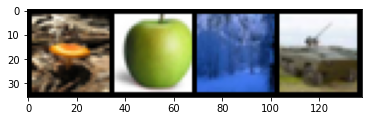

mushroom apple forest tank 


In [12]:
# get some random training images
# The "iter( )" function makes an object iterable.
# Meaning that we still can't subscribt it, however we can call the next 
# "instance" (I guess is an apt name), over and over. 
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
gridedImages = utils.make_grid(images[:4])
npimg = gridedImages.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

# print labels
print(" ".join(f"{classes[labels[j]]:5s}" for j in range(4)))

## Downloading the ResNet18 model

Getting the model pytorch's own pretrained models.

In [13]:
# Returns the resnet18 
model = models.resnet18(pretrained=False).to(device)


## Defining loss and optimization function

Both the loss function and the optimization function needs to be defined for this particular neural network.
They are defined as follows.

(Why it is always that CrossEntropyLoss.. I do not know)

In [14]:
lrn_rt = 1e-3

loss_fn = nn.CrossEntropyLoss()

# We are just going to use Adam, because it has proven to be effective.
optimizer = optim.Adam(model.parameters(), lr=lrn_rt, weight_decay=1e-3)

## Checkpoint shenaniganz
It is quite useful to have checkpoints when training humongous models, that is what this code handles.

In [15]:
# It is important that it is initialized to zero
# if we are in the case that a model hasn't been trained yet.
accuracies = np.zeros((2, numEpochs))
losses = np.zeros((2, numEpochs))
            
# exists is a function from os.path (standard library)
trained_model_exists = exists(saveModelPath)

if trained_model_exists:
    if completelyRestartTrain:
        os.remove(saveModelPath)
        startEpoch = 0
        msg("Previous model was deleted. \nRestarting training.")
    else:
        import collections
        if not (type(torch.load(saveModelPath)) is collections.OrderedDict):
            ## If it looks stupid but works it ain't stupid B)
            #
            # I think if it isn't that datatype, then it saved the Alex-way
            # and then we can load stuff.
            # Because if it is that datatype then it is for sure "just" the state_dict.
            
            checkpoint = torch.load(saveModelPath)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            
            num_previous_epochs = checkpoint['accuracies'].shape[1]
            
            if num_previous_epochs < numEpochs:
                # if we trained to fewer epochs previously,
                # now we train to the proper amount, therfore padded zeroes are required.
                remainingZeros = np.zeros((2,numEpochs-num_previous_epochs))
                checkpoint['accuracies'] = np.concatenate((checkpoint['accuracies'], remainingZeros), axis=1)
                checkpoint['losses'] = np.concatenate((checkpoint['losses'], remainingZeros), axis=1)
                
            if numEpochs < num_previous_epochs:
                # Just cut off our data at the required amount of epochs, so nothing looks funky.
                checkpoint['accuracies'] = checkpoint['accuracies'][:,:numEpochs]
                checkpoint['losses'] = checkpoint['losses'][:,:numEpochs]
            
            # we save at the epoch we completed, but we wan't to start at the following epoch
            startEpoch = checkpoint['epoch'] + 1 
            
            if startEpoch < numEpochs:
                # we add one to startEpoch here (in the message) to make up for
                # the for-loop being zero-indexed.
                msg(f"Model will resume training from epoch: {startEpoch + 1}")
                
                # grapping our accuracies from the previously trained model
                accuracies = checkpoint['accuracies']
                losses = checkpoint['losses']
                
            elif tryResumeTrain and startEpoch >= numEpochs:
                msg("Model has already finished training. "
                    + "\nDo you wan't to delete previous model and start over?")
                userInput = input("Input [y/n]:\t")
                while userInput.lower() != 'y' and userInput.lower != 'n':
                    userInput = input("You must input either 'y' (yes) or 'n' (no):\t")
                if userInput.lower() == "y":
                    os.remove(saveModelPath)
                    startEpoch = 0
                    msg("Previous model was deleted. \nRestarting training!")
                elif userInput.lower() == "n":
                    msg("Model had already finished training and no new training will commence.")
                    
            elif not tryResumeTrain and startEpoch >= numEpochs:
                msg(f"Model finished training at epoch: {startEpoch}")
                # grapping our accuracies from the previously trained model
                accuracies = checkpoint['accuracies']
                losses = checkpoint['losses']
                            
else:
    #Trained model doesn't exist
    msg("There was no previously existing model. \nTraining will commence from beginning.")
    startEpoch = 0
    
            


>>>>>>>>>>>>>>>>>>>  <<<<<<<<<<<<<<<<<<<
There was no previously existing model. 
Training will commence from beginning.
>>>>>>>>>>>>>>>>>>>  <<<<<<<<<<<<<<<<<<<



## The Training and Testing Loop

The loops for training and testing:

In [16]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    
    for batch, data in enumerate(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Compute prediction and loss
        pred = model(inputs)
        loss = loss_fn(pred, labels)
        
        train_loss += loss.item()
        correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        current_batch_size = len(inputs)

        if (batch + 1) % (10000//current_batch_size) == 0:
            loss, current = loss.item(), batch * current_batch_size
            print(f"Train loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    train_loss /= num_batches        
    correct /= size
    return 100*correct, train_loss


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for data in dataloader:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
        
            pred = model(inputs)
            test_loss += loss_fn(pred, labels).item()
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error (on validation set): \n Accuracy: {(100*correct):>0.1f}%, Avg test loss: {test_loss:>8f} \n")
    
    return 100*correct, test_loss

## Training the network

Obviously we also need to fit some weights, so here is the code for training the network.

In [17]:
# We train if we haven't already trained
# or we want to train again.
if not trained_model_exists or tryResumeTrain or startEpoch < (numEpochs - 1):

    for t in range(startEpoch, numEpochs):
        print(f"Epoch {t+1}\n-------------------------------")
        accuracyTrain, avglossTrain = train_loop(train_loader, model, loss_fn, optimizer)
        accuracyTest, avglossTest = test_loop(val_loader, model, loss_fn)
        
        # This is just extra for plotting
        accuracies[0,t], accuracies[1,t] = accuracyTest, accuracyTrain
        losses[0,t], losses[1,t] = avglossTest, avglossTrain
        
        # Checkpoint
        torch.save({
            'epoch': t,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'accuracies': accuracies,
            'losses': losses
            }, saveModelPath)
        print(f"Checkpoint at epoch: {t + 1}")
        
    msg(f"Done! Final model was saved to: \n'{saveModelPath}'")
    
else:
    msg("Have already trained this model once!")



Epoch 1
-------------------------------


KeyboardInterrupt: 